In [ ]:
!pip install wordcloud --upgrade
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

In [1]:
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)
from termcolor import colored
from wordcloud import WordCloud, STOPWORDS

# DataFrame
import pandas as pd 

# Matplotlib
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Word embeddig : word2vec
import gensim

# Log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Dataset Values
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# Tweet Cleaning
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Word Embedding Word2Vec 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Keras
SEQUENCE_LENGTH = 300
EPOCHS = 10
BATCH_SIZE = 1024


# Sentiments
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Models
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:

dataset_path = os.path.join("./data/dataset.csv")
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print("Dataset size:", len(df))

Dataset size: 1600000


2020-08-07 13:42:32,439 : WARNING : No handles with labels found to put in legend.


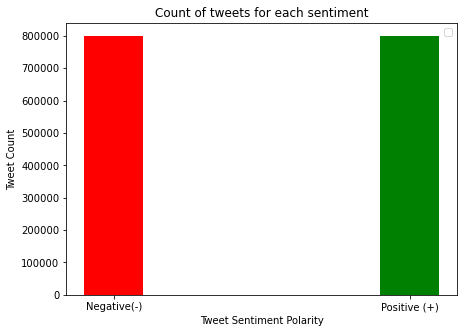

In [4]:
class_count = df['target'].value_counts() 
plt.figure(figsize = (7, 5))
plt.xticks([4, 0], ['Positive (+)', 'Negative(-)'])
plt.xticks([4, 0])
plt.bar(x = class_count.keys(), 
        height = class_count.values, 
        color = ['g', 'r'])
plt.xlabel("Tweet Sentiment Polarity")
plt.ylabel("Tweet Count")
plt.title("Count of tweets for each sentiment")
plt.legend()

In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}

def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 614 ms


In [7]:
target_cnt = Counter(df.target)

In [8]:
# data preprocessing

In [9]:
stop_words = set(stopwords.words("english"))
stop_words.remove("not")
stop_words.remove("no")
stop_words= list(stop_words)
stemmer = SnowballStemmer("english")

In [10]:
# Function to expand n't to not
def expand_text(text):
	expanded_text = []
	for word in text:
		if re.search("n't", word):
			expanded_text.append(word.split("n't")[0])
			expanded_text.append("not")
		else:
			expanded_text.append(word)
	return " ".join(expanded_text)

In [11]:
def preprocess(text, stem=False):
#     text = expand_text(text)
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 5s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 3.59 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [16]:
w2v_model.build_vocab(documents)

2020-08-07 13:43:56,864 : INFO : collecting all words and their counts
2020-08-07 13:43:56,866 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-07 13:43:56,907 : INFO : PROGRESS: at sentence #10000, processed 73708 words, keeping 14007 word types
2020-08-07 13:43:56,941 : INFO : PROGRESS: at sentence #20000, processed 146656 words, keeping 21589 word types
2020-08-07 13:43:56,970 : INFO : PROGRESS: at sentence #30000, processed 219263 words, keeping 27543 word types
2020-08-07 13:43:57,000 : INFO : PROGRESS: at sentence #40000, processed 292891 words, keeping 32766 word types
2020-08-07 13:43:57,033 : INFO : PROGRESS: at sentence #50000, processed 365542 words, keeping 37589 word types
2020-08-07 13:43:57,083 : INFO : PROGRESS: at sentence #60000, processed 438403 words, keeping 42200 word types
2020-08-07 13:43:57,123 : INFO : PROGRESS: at sentence #70000, processed 511220 words, keeping 46460 word types
2020-08-07 13:43:57,158 : INFO : PROGRESS: at s

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30371


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-07 13:44:09,121 : INFO : training model with 8 workers on 30371 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-07 13:44:10,173 : INFO : EPOCH 1 - PROGRESS: at 7.91% examples, 640347 words/s, in_qsize 16, out_qsize 1
2020-08-07 13:44:11,204 : INFO : EPOCH 1 - PROGRESS: at 16.22% examples, 654759 words/s, in_qsize 16, out_qsize 7
2020-08-07 13:44:12,207 : INFO : EPOCH 1 - PROGRESS: at 24.86% examples, 674535 words/s, in_qsize 14, out_qsize 1
2020-08-07 13:44:13,215 : INFO : EPOCH 1 - PROGRESS: at 33.27% examples, 679441 words/s, in_qsize 15, out_qsize 3
2020-08-07 13:44:14,232 : INFO : EPOCH 1 - PROGRESS: at 41.67% examples, 681196 words/s, in_qsize 16, out_qsize 3
2020-08-07 13:44:15,252 : INFO : EPOCH 1 - PROGRESS: at 50.71% examples, 690649 words/s, in_qsize 15, out_qsize 0
2020-08-07 13:44:16,291 : INFO : EPOCH 1 - PROGRESS: at 59.35% examples, 690541 words/s, in_qsize 16, out_qsize 0
2020-08-07 13:44:17,299 : INFO : EPOCH 1 - PROGRESS: 

Wall time: 7min 17s


(265764806, 300020352)

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290421
Wall time: 22.2 s


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 31 s


In [21]:
#labels : sentiment polarity
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [24]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [25]:
# word2vec Matrix for Embedding layer 
print("W2V_SIZE : ",W2V_SIZE)
print("vocab_size : ",vocab_size)

embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

W2V_SIZE :  300
vocab_size :  290421
(290421, 300)


In [26]:
#Embedding layer 
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [27]:
# Model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87126300  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,801
Trainable params: 160,501
Non-trainable params: 87,126,300
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [29]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [30]:
# Train Model

In [31]:
%%time
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=callbacks)

  27/1125 [..............................] - ETA: 3:57:26 - loss: 0.6059 - accuracy: 0.6636

KeyboardInterrupt: 

In [32]:
# Evaluate

In [33]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 565s 2s/step - loss: 0.5394 - accuracy: 0.7341

ACCURACY: 0.7341312766075134
LOSS: 0.5394225120544434


In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'history' is not defined

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    score = model.predict([x_test])[0] # Predict
    label = decode_sentiment(score, include_neutral=include_neutral)  # sentiment extraction

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
#Perdict example
predict("I love the music")

In [ ]:
#Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=35)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion Matrix")
plt.show()

In [ ]:
#Results

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))   # Classification Final Results

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)   #Accuracy Score

In [ ]:
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)